# FNC

In [11]:
%pip install torch torchvision
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

%pip install numpy
import numpy as np

import os


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, image_set='train', transform=None):
        self.root_dir = root_dir
        self.image_set = image_set
        self.transform = transform
        
        # Load the image file paths and their corresponding segmentation mask paths
        self.images = []
        self.masks = []
        
        with open(os.path.join(root_dir, 'VOC2012_train_val', 'ImageSets', 'Segmentation', f'{image_set}.txt'), 'r') as f:
            image_ids = f.readlines()
        
        # Collect image paths and their corresponding segmentation masks
        for image_id in image_ids:
            image_id = image_id.strip()
            image_path = os.path.join(root_dir, 'VOC2012_train_val', 'JPEGImages', f'{image_id}.jpg')
            mask_path = os.path.join(root_dir, 'VOC2012_train_val', 'SegmentationClass', f'{image_id}.png')
            
            self.images.append(image_path)
            self.masks.append(mask_path)
        
        print(f"Loaded {len(self.images)} images and masks from the dataset.")
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        print(f"Loading sample {idx}...")
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])

        print(f"Image loaded from {self.images[idx]} with size {image.size}")
        print(f"Mask loaded from {self.masks[idx]} with size {mask.size}")

        # Resize image and mask
        if self.transform:
            print("Applying transformations...")
            image = self.transform(image)
            print(f"Image transformed to tensor with shape {image.shape}")

            # Resize mask to match the image size (256, 256)
            mask = mask.resize((256, 256), Image.NEAREST)  # Resize mask to 256x256 directly
            print(f"Mask resized to {mask.size}")

            # Convert mask to numpy array and then to tensor
            mask = np.array(mask)  # Convert mask to numpy array
            print(f"Mask converted to numpy array with shape {mask.shape}")

            # Replace 255 (ignore) with -1 for the CrossEntropyLoss
            mask[mask == 255] = -1  # Ignore label
            print(f"Mask after replacing 255 with -1 (ignore label)")

            mask = torch.from_numpy(mask).long()  # Convert mask to tensor (long type)
            print(f"Mask converted to tensor with shape {mask.shape}")

        return image, mask


In [13]:
# Define transformations (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize images to 256x256 for faster processing
    transforms.ToTensor(),           # Convert image to tensor
])

# Initialize the dataset
train_dataset = PascalVOCDataset(root_dir='./dataset/VOC2012_train_val', image_set='train', transform=transform)
val_dataset = PascalVOCDataset(root_dir='./dataset/VOC2012_train_val', image_set='val', transform=transform)

# Create DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Loaded 1464 images and masks from the dataset.
Loaded 1449 images and masks from the dataset.


Loading sample 0...
Image loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2007_000032.jpg with size (500, 281)
Mask loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2007_000032.png with size (500, 281)
Applying transformations...
Image transformed to tensor with shape torch.Size([3, 256, 256])
Mask resized to (256, 256)
Mask converted to numpy array with shape (256, 256)
Mask after replacing 255 with -1 (ignore label)
Mask converted to tensor with shape torch.Size([256, 256])
Sample image type: <class 'torch.Tensor'>
Sample mask type: <class 'torch.Tensor'>
Sample image shape: torch.Size([3, 256, 256])
Sample mask shape: torch.Size([256, 256])


/var/folders/jk/nydd6s6n72nb5jfk957jjyd80000gn/T/ipykernel_23375/3203233718.py:51: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  mask[mask == 255] = -1  # Ignore label


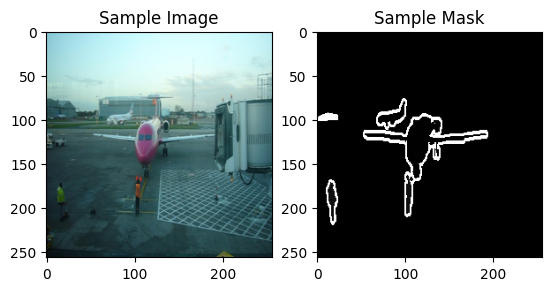

In [14]:
# Test a single sample from the dataset
sample_image, sample_mask = train_dataset[0]  # Fetch the first image and mask from the dataset

# Check the types of the image and mask
print(f"Sample image type: {type(sample_image)}")
print(f"Sample mask type: {type(sample_mask)}")

# Check the shape of the image and mask
print(f"Sample image shape: {sample_image.shape if isinstance(sample_image, torch.Tensor) else 'Not a tensor'}")
print(f"Sample mask shape: {sample_mask.shape if isinstance(sample_mask, torch.Tensor) else 'Not a tensor'}")

# Optionally, you can visualize the image and mask using matplotlib
import matplotlib.pyplot as plt

# Convert the tensor image to numpy for visualization
sample_image_np = sample_image.permute(1, 2, 0).numpy()  # Convert CHW to HWC format for plotting
plt.subplot(1, 2, 1)
plt.imshow(sample_image_np)
plt.title("Sample Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask.numpy(), cmap='gray')
plt.title("Sample Mask")
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleFCN(nn.Module):
    def __init__(self, num_classes=21):  # Pascal VOC has 21 classes (including background)
        super(SimpleFCN, self).__init__()
        
        # Define the architecture
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc = nn.Conv2d(256, num_classes, kernel_size=1)  # Output layer
        
    def forward(self, x):
        # Pass through the layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.fc(x)
        
        return x


In [16]:
# Define the number of classes (including the 'ignore' class)
num_classes = 21  # For Pascal VOC, the classes range from 0 to 20, and 255 is used for ignore

# Define the CrossEntropyLoss with ignore_index set to 255
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)  # Ignore label (-1 is ignored)


# Initialize the model
model = SimpleFCN(num_classes=num_classes)  # For Pascal VOC, we have 21 classes

# Initialize the loss function (cross-entropy)
criterion = nn.CrossEntropyLoss()

In [17]:
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
def evaluate(model, val_loader, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to compute gradients during evaluation
        correct_pixels = 0
        total_pixels = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predicted labels (argmax over channels)
            _, predicted = torch.max(outputs, 1)  # (N, C, H, W) -> (N, H, W)
            
            # Count correct pixels and total pixels
            correct_pixels += (predicted == targets).sum().item()
            total_pixels += targets.numel()
        
        # Compute pixel accuracy
        accuracy = correct_pixels / total_pixels
        print(f"Validation Accuracy: {accuracy:.4f}")


In [19]:
# Debugging single batch from the DataLoader
for inputs, targets in train_loader:
    print(f"Inputs type: {type(inputs)}, Targets type: {type(targets)}")
    print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")
    break  # Only print for the first batch


Loading sample 579...
Image loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2008_006221.jpg with size (500, 333)
Mask loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2008_006221.png with size (500, 333)
Applying transformations...
Image transformed to tensor with shape torch.Size([3, 256, 256])
Mask resized to (256, 256)
Mask converted to numpy array with shape (256, 256)
Mask after replacing 255 with -1 (ignore label)
Mask converted to tensor with shape torch.Size([256, 256])
Loading sample 821...
Image loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2009_003034.jpg with size (500, 333)
Mask loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2009_003034.png with size (500, 333)
Applying transformations...
Image transformed to tensor with shape torch.Size([3, 256, 256])
Mask resized to (256, 256)
Mask converted to numpy array with shape (256, 256)
Mask after replacing 255 with -1 (ignore labe

/var/folders/jk/nydd6s6n72nb5jfk957jjyd80000gn/T/ipykernel_23375/3203233718.py:51: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  mask[mask == 255] = -1  # Ignore label


In [20]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = model.to(device)
criterion = criterion.to(device)

# Training loop
num_epochs = 10  # You can adjust the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # Move inputs and targets to device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Optionally: evaluate the model on the validation set after every epoch
    if (epoch + 1) % 5 == 0:
        evaluate(model, val_loader, device)


Loading sample 741...
Image loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2009_001782.jpg with size (500, 375)
Mask loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2009_001782.png with size (500, 375)
Applying transformations...
Image transformed to tensor with shape torch.Size([3, 256, 256])
Mask resized to (256, 256)
Mask converted to numpy array with shape (256, 256)
Mask after replacing 255 with -1 (ignore label)
Mask converted to tensor with shape torch.Size([256, 256])
Loading sample 1084...
Image loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2010_002720.jpg with size (500, 328)
Mask loaded from ./dataset/VOC2012_train_val/VOC2012_train_val/SegmentationClass/2010_002720.png with size (500, 328)
Applying transformations...
Image transformed to tensor with shape torch.Size([3, 256, 256])
Mask resized to (256, 256)
Mask converted to numpy array with shape (256, 256)
Mask after replacing 255 with -1 (ignore lab

/var/folders/jk/nydd6s6n72nb5jfk957jjyd80000gn/T/ipykernel_23375/3203233718.py:51: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  mask[mask == 255] = -1  # Ignore label


IndexError: Target 255 is out of bounds.